In [164]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re
from config import *
from clustering_utils import *

# Sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, HDBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from kneed import KneeLocator
from scipy import stats


from scipy.cluster.hierarchy import dendrogram, linkage

import umap

# Visual
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from itertools import permutations 
from tqdm import tqdm

In [165]:
all_features_with_info_raw = (pd.read_parquet(FEATURES_DIR / "all_features.pq"))
all_features_with_info_raw = all_features_with_info_raw[~(all_features_with_info_raw.isna().sum(axis=1) == all_features_with_info_raw.shape[1]-2)]


y = pd.DataFrame(all_features_with_info_raw["y"], columns=["y"])


all_features_with_info = (all_features_with_info_raw
        .pipe(remove_low_variance_features)
        .pipe(remove_multicollineraity, y)
        .pipe(remove_outliers, 10.0)
)



X = (all_features_with_info.query("y==1")
 .drop(["participant_id", "y"], axis=1)
 .dropna()
)

X_stdz = pd.DataFrame(StandardScaler().fit_transform(X.values), columns=X.columns)
X_stdz

/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
2025-05-09 15:15:37,406 - INFO - clustering_utils.remove_low_variance_features:50 - Kept 473 features out of 520
2025-05-09 15:15:37,493 - INFO - clustering_utils.remove_multicollineraity:108 - Removed 165 highly correlated features: {'SHAPES_duration_mean_fix', 'REACTION_total_acceleration_magnitude_std', 'EVIL_BASTARD_avg_pupil_size_median_fix', 'SHAPES_amplitude_mean_sacc', 'SMOOTH_PURSUITS_avg_pupil_size_min_fix', 'REACTION_peak_velocity_mean_sacc', 'EVIL_BASTARD_fixations_per_second_min', 'KING_DEVICK_avg_pupil_size_mean_fix', 'SHAPES_fixations_per_second_max', 'KING_DEVICK_duration_max_fix', 'FITTS_LAW_fixations_per_second_median', 'FITTS_LAW_avg_pupil_size_min_fix', 'ANTI_SACCADE_avg_pupil_size_min_fix', 'KING_DE

,ANTI_SACCADE_peak_velocity_min_sacc,ANTI_SACCADE_peak_velocity_max_sacc,ANTI_SACCADE_peak_velocity_median_sacc,ANTI_SACCADE_peak_velocity_std_sacc,ANTI_SACCADE_amplitude_mean_sacc,ANTI_SACCADE_amplitude_min_sacc,ANTI_SACCADE_amplitude_max_sacc,ANTI_SACCADE_amplitude_median_sacc,ANTI_SACCADE_amplitude_std_sacc,ANTI_SACCADE_duration_mean_sacc,...,SMOOTH_PURSUITS_y_acceleration_std,SMOOTH_PURSUITS_Var_total,SMOOTH_PURSUITS_distance_to_fixpoint_min,SMOOTH_PURSUITS_distance_to_fixpoint_median,SMOOTH_PURSUITS_distance_to_fixpoint_x_max,SMOOTH_PURSUITS_distance_to_fixpoint_x_median,SMOOTH_PURSUITS_distance_to_fixpoint_y_min,SMOOTH_PURSUITS_distance_to_fixpoint_y_max,SMOOTH_PURSUITS_distance_to_fixpoint_y_median,SMOOTH_PURSUITS_distance_to_fixpoint_y_std
0,0.588982,-1.039149,0.084308,-0.747831,0.430898,1.430449,0.077568,0.719743,-0.133703,-1.142996,...,-0.779059,-0.451600,0.777252,0.831099,0.359675,1.320669,-0.579324,0.581344,-0.041328,0.761614
1,-1.795478,-0.993121,-1.431970,-0.701053,-0.789057,-1.267206,-0.212975,-0.976129,-0.190362,0.985642,...,1.224071,0.101882,-0.196061,0.096283,1.601696,0.444129,-0.579324,0.955130,-0.312898,-0.356629
2,0.032608,-0.017888,0.545784,0.155855,-0.380450,-0.296050,-0.569429,-0.352107,-0.453017,0.585665,...,0.142507,1.437297,-0.305495,2.679262,-0.547216,3.036502,-0.579324,1.028861,2.724007,1.664686
3,-0.285320,-0.748593,-0.838644,-0.632501,-0.411557,-0.511863,-0.026005,-0.770569,0.025420,-0.442455,...,-0.466624,-1.225880,-0.405721,2.677983,0.458173,1.003537,1.034507,1.171616,2.462883,2.782333
4,0.191572,1.800246,-1.835761,0.967658,-1.630150,-1.051394,-1.263505,-1.460664,-1.120691,2.277069,...,0.315900,0.301865,-0.808737,-0.531911,0.939455,-0.809073,-0.579324,-0.899171,-0.204371,-0.734817
5,0.191572,0.371918,-0.443093,-0.041845,-1.031577,0.783012,-1.162622,-0.260339,-1.211502,-1.157125,...,-0.708574,0.558088,0.229732,0.092158,-0.097362,0.673651,-0.579324,-0.594295,-0.307950,0.827416
6,0.509500,2.326699,2.507057,2.150652,-0.608756,-0.511863,-0.831725,-0.506277,-0.627926,1.467791,...,-0.421669,1.005339,1.791789,-0.517528,-0.861182,0.291388,-0.579324,0.691241,-0.641882,-0.026198
7,0.350536,3.089049,1.155592,4.879895,0.332285,-0.403957,0.405774,-0.029083,0.467155,1.903484,...,0.776161,-0.667807,-0.621854,-0.105705,1.463928,-0.106888,-0.579324,1.226861,-0.602941,-0.009594
8,-0.046874,1.708188,0.125511,0.291587,2.125014,0.890918,1.418641,1.564009,1.584596,0.518043,...,0.266274,2.010532,-0.740752,1.041571,1.197436,1.086105,-0.579324,0.501846,1.105432,1.208454
9,0.350536,-0.226455,-1.201232,-0.242059,-0.543672,1.214637,-0.023315,-0.498935,-0.480146,-0.720238,...,-0.471972,-0.952966,-0.166099,-0.260268,-1.436289,-0.734751,-0.579324,-1.766178,0.179219,-1.020888


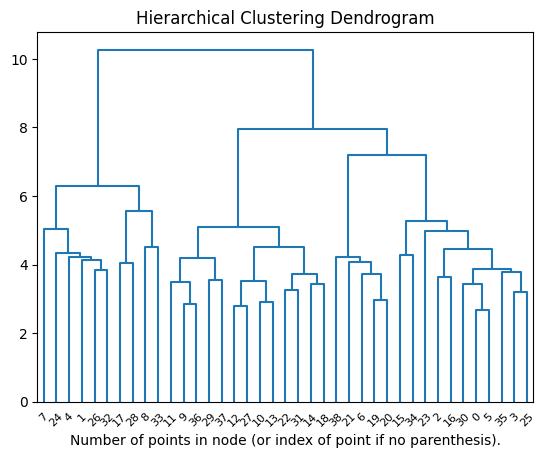

In [163]:



def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0,n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode = 'level', p=100, color_threshold=0)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [141]:
n_clusters_to_try = range(2,15)

clustering_results = {
    "n_clusters": [],
    "silhouette_scores": [],
    "labels": []
}

for n_cluster in n_clusters_to_try:
    model = AgglomerativeClustering(n_clusters=n_cluster)
    model.fit(X)
    labels = model.labels_
    sil_score = silhouette_score(X, labels)
    clustering_results["silhouette_scores"].append(sil_score)
    clustering_results["n_clusters"].append(n_cluster)
    clustering_results["labels"].append(model.labels_)

clustering_results = pd.DataFrame(clustering_results)

In [162]:
clustering_results

,n_clusters,silhouette_scores,labels
0,2,0.145089,"[0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."
1,3,0.071833,"[0, 1, 0, 0, 1, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, ..."
2,4,0.083266,"[1, 0, 1, 1, 0, 1, 3, 0, 0, 2, 2, 2, 2, 2, 2, ..."
3,5,0.091751,"[1, 4, 1, 1, 4, 1, 3, 4, 0, 2, 2, 2, 2, 2, 2, ..."
4,6,0.094208,"[0, 1, 0, 0, 1, 0, 3, 1, 4, 2, 2, 2, 2, 2, 2, ..."
5,7,0.086984,"[2, 1, 2, 2, 1, 2, 3, 1, 4, 0, 0, 0, 0, 0, 0, ..."
6,8,0.066121,"[2, 0, 2, 2, 0, 2, 3, 0, 1, 7, 4, 7, 4, 4, 4, ..."
7,9,0.064840,"[0, 2, 0, 0, 2, 0, 3, 8, 1, 7, 4, 7, 4, 4, 4, ..."
8,10,0.065752,"[4, 2, 4, 4, 2, 4, 3, 8, 0, 7, 1, 7, 1, 1, 1, ..."
9,11,0.064052,"[1, 2, 1, 1, 2, 1, 3, 8, 10, 7, 0, 7, 0, 0, 0,..."


In [150]:
feature_importance_results = {
    'best_params': [],
    'n_clusters': [],
    'feature_importances': [],
    'silhouette_scores': [],
    'labels': []
}

for i, row in tqdm(clustering_results.iterrows(), total=clustering_results.shape[0]):
    n_cluster = row["n_clusters"]
    silhoette_scores = row["silhouette_scores"]
    y = row["labels"]
    # Initialize results

    feature_importances = pd.DataFrame(
        np.zeros(X.shape[1]), 
        columns=["Importance"], 
        index=X.columns)

    # Hyperparameters for GridSearch
    parameters = {
        'max_depth': [None, 3, 5, 7, 9, 11],
        'n_estimators': [20, 30, 40, 50, 70, 100],
        'max_features': ['sqrt', 'log2']
    }


    # Find best clf
    grid_search = GridSearchCV(
        RandomForestClassifier(n_jobs=-1, random_state=42), 
        parameters, 
        cv=2,
        verbose=1, 
        n_jobs=-1)

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    importances = best_model.feature_importances_
    best_params = grid_search.best_params_

    # update importances
    feature_importances.loc[X.columns, "Importance"] += importances
    
    feature_importance_results["best_params"].append(best_params)
    feature_importance_results["feature_importances"].append(feature_importances)
    feature_importance_results['n_clusters'].append(n_cluster)
    feature_importance_results["silhouette_scores"].append(silhoette_scores)
    feature_importance_results["labels"].append(y)



  0%|          | 0/13 [00:00<?, ?it/s]

Fitting 2 folds for each of 72 candidates, totalling 144 fits


  8%|▊         | 1/13 [00:01<00:19,  1.60s/it]

Fitting 2 folds for each of 72 candidates, totalling 144 fits


 15%|█▌        | 2/13 [00:03<00:17,  1.55s/it]

Fitting 2 folds for each of 72 candidates, totalling 144 fits


 23%|██▎       | 3/13 [00:04<00:15,  1.56s/it]

Fitting 2 folds for each of 72 candidates, totalling 144 fits


 31%|███       | 4/13 [00:06<00:14,  1.57s/it]

Fitting 2 folds for each of 72 candidates, totalling 144 fits


 38%|███▊      | 5/13 [00:07<00:12,  1.59s/it]

Fitting 2 folds for each of 72 candidates, totalling 144 fits


 46%|████▌     | 6/13 [00:09<00:11,  1.58s/it]

Fitting 2 folds for each of 72 candidates, totalling 144 fits


 54%|█████▍    | 7/13 [00:10<00:09,  1.56s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 72 candidates, totalling 144 fits


 62%|██████▏   | 8/13 [00:12<00:07,  1.55s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 72 candidates, totalling 144 fits


 69%|██████▉   | 9/13 [00:14<00:06,  1.56s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 72 candidates, totalling 144 fits


 77%|███████▋  | 10/13 [00:15<00:04,  1.54s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 72 candidates, totalling 144 fits


 85%|████████▍ | 11/13 [00:17<00:03,  1.56s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 72 candidates, totalling 144 fits


 92%|█████████▏| 12/13 [00:18<00:01,  1.56s/it]/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 72 candidates, totalling 144 fits


100%|██████████| 13/13 [00:20<00:00,  1.56s/it]


In [151]:
selected_features_results = {
    'best_params': [],
    'selected_features': [],
    "n_clusters": [],
    "silhouette_scores": [],
    "labels": []
    
}

for i, feature_importances in enumerate(feature_importance_results["feature_importances"]):
    
    sorted_feature_importance = (feature_importances
    .sort_values("Importance", ascending=False)
    .reset_index()
    )

    importance_values = sorted_feature_importance["Importance"].values
    feature_ranks = np.arange(len(importance_values))

    # Find knee
    knee = KneeLocator(
        feature_ranks, 
        importance_values, 
        curve='convex', 
        direction='decreasing'
    )
    knee_point = knee.knee

    if knee_point is not None:
        logging.info(f"Knee detected at feature rank {knee_point}")
    else:
        logging.warning("Knee point is not detected")
        knee_point = len(sorted_feature_importance) - 1

    # Select features above knee
    selected_features = sorted_feature_importance.iloc[:knee_point+1]
    logging.info(f"Automatically selected {selected_features.shape[0]} features")

    selected_features_results["selected_features"].append(selected_features)
    selected_features_results["n_clusters"].append(feature_importance_results["n_clusters"][i])
    selected_features_results["silhouette_scores"].append(feature_importance_results["silhouette_scores"][i])
    selected_features_results["labels"].append(feature_importance_results["labels"][i])
    selected_features_results["best_params"].append(feature_importance_results["best_params"][i])


2025-05-09 15:06:35,570 - INFO - 3871393310.<module>:30 - Knee detected at feature rank 23
2025-05-09 15:06:35,570 - INFO - 3871393310.<module>:37 - Automatically selected 24 features
2025-05-09 15:06:35,571 - INFO - 3871393310.<module>:30 - Knee detected at feature rank 18
2025-05-09 15:06:35,571 - INFO - 3871393310.<module>:37 - Automatically selected 19 features
2025-05-09 15:06:35,572 - INFO - 3871393310.<module>:30 - Knee detected at feature rank 42
2025-05-09 15:06:35,573 - INFO - 3871393310.<module>:37 - Automatically selected 43 features
2025-05-09 15:06:35,574 - INFO - 3871393310.<module>:30 - Knee detected at feature rank 31
2025-05-09 15:06:35,574 - INFO - 3871393310.<module>:37 - Automatically selected 32 features
2025-05-09 15:06:35,575 - INFO - 3871393310.<module>:30 - Knee detected at feature rank 33
2025-05-09 15:06:35,575 - INFO - 3871393310.<module>:37 - Automatically selected 34 features
2025-05-09 15:06:35,576 - INFO - 3871393310.<module>:30 - Knee detected at featu

In [161]:
pd.concat(selected_features_results["selected_features"]).groupby("index").mean()




,Importance
index,
ANTI_SACCADE_amplitude_max_sacc,0.007991
ANTI_SACCADE_amplitude_mean_sacc,0.029804
ANTI_SACCADE_amplitude_median_sacc,0.007917
ANTI_SACCADE_amplitude_min_sacc,0.011451
ANTI_SACCADE_amplitude_std_sacc,0.008710
...,...
SMOOTH_PURSUITS_x_acceleration_std,0.030648
SMOOTH_PURSUITS_x_fixation_dist_min,0.010448
SMOOTH_PURSUITS_y_acceleration_mean,0.012683
